In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2



st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [4]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [5]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [10]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [6]:
%matplotlib inline
plt.close("all")

# Scan inner in flux expansion

In [7]:
pstore = {}

In [8]:
d = eqb["SPR45"]["il"]
base = Profile(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
new = base.copy()

BxBt_base = base.get_total_flux_expansion()
list_BxBt = np.concatenate([np.linspace(BxBt_base/2, BxBt_base, 5), np.linspace(BxBt_base, BxBt_base*2, 5)])
list_BxBt = np.unique(list_BxBt)

profiles = {}
for BxBt in list_BxBt:
    profiles[BxBt] = base.copy()
    profiles[BxBt].scale_BxBt(BxBt = BxBt, verbose = False)
    
pstore["inner_BxBt"] = profiles.copy()


# Inner BxBt scan

In [11]:
store = dict()
profiles = pstore["inner_BxBt"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]], 10) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9
    elif "o" in side:
        constants["qpllu0"] = 2.0e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    store[i] = copy.deepcopy(results)


 Profile: 0.3578835827072183
Solving...0...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


6...11...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


15...18...20...21...22...23...24...Complete in 21.3 seconds

 Profile: 0.44735447838402287
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.2 seconds

 Profile: 0.5368253740608275
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.6 seconds

 Profile: 0.6262962697376321
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.4 seconds

 Profile: 0.7157671654144366
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.9 seconds

 Profile: 0.8947089567680457
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.2 seconds

 Profile: 1.073650748121655
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 21.1 seconds

 Profile: 1.2525925394752642
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 23.3 seconds

 Profile: 1.4315343308288733
Solving...0...6...11...15...18...20...21...22...23...24...Complete in 23.6 seconds


C:\Users\mikek\AppData\Local\Temp\ipykernel_37700\1326401310.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


Text(0.5, 1.0, 'Front position response to upstream density')

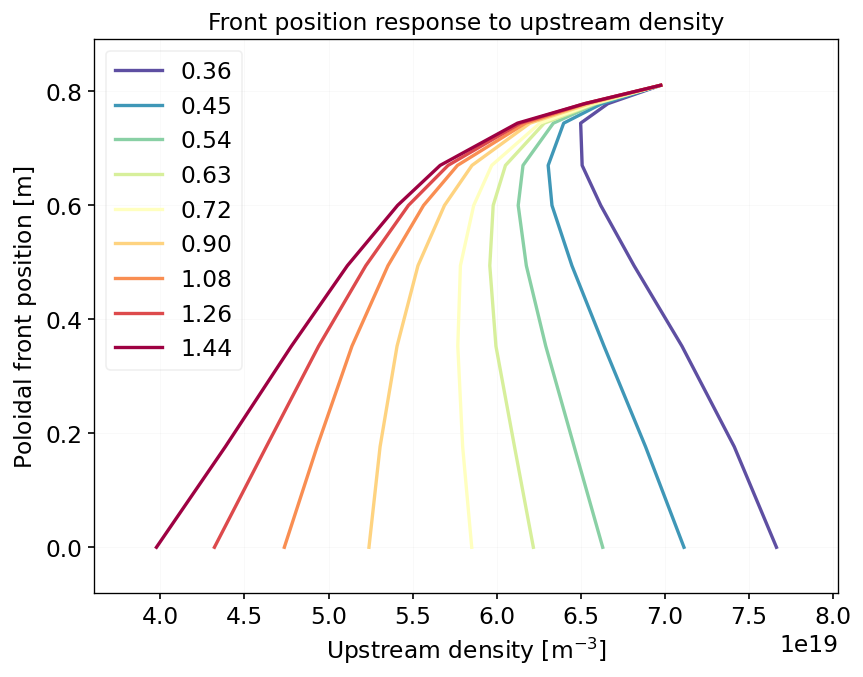

In [25]:
fig, ax = plt.subplots()
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar"], s["SpolPlot"], label = f"{id:.2f}", color = colors[i], **style)
    
ax.legend()
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

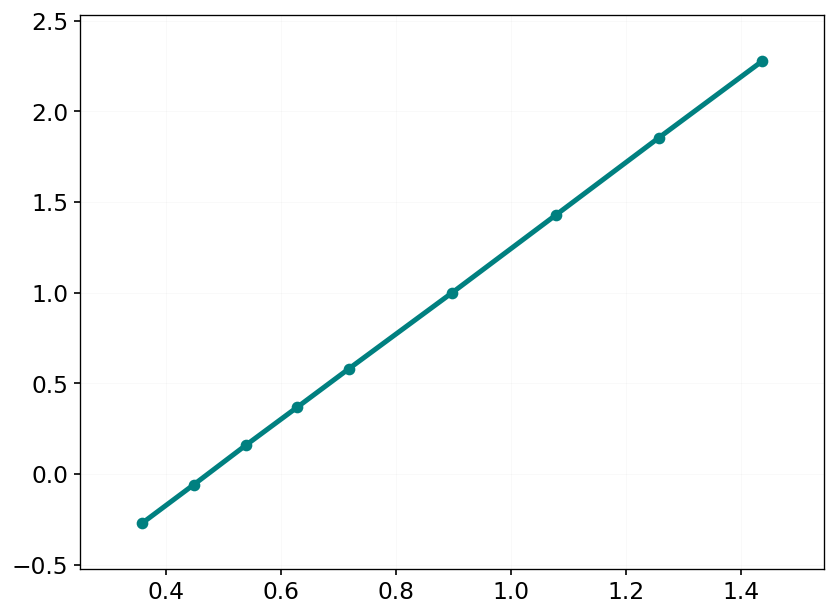

In [39]:
outputs = list(store.values())
o = outputs[-1]

for id in store:
    o = store[id]
    window = (o["crel"][-1] - 1)
    window_ratio = o["crel"][-1]
    window_old = o["cvar"][-1] - o["cvar"][-2]
    
    # print(f"{id:.2f} : {window:.2f} : {window_old:.2f}")
    
windows = np.array([store[x]["crel"][-1] - 1 for x in profiles])
old_windows = np.array([store[x]["window"] for x in profiles])
thresholds = np.array([store[x]["threshold"] for x in profiles])
# old_windows /= old_windows[0]
# old_windows = old_windows / old_windows[5]

old_windows / thresholds

fig, ax = plt.subplots()
ax.plot(store.keys(), windows / windows[5], marker = "o", label = "Old calculation")
# ax.plot(store.keys(), old_windows / thresholds, marker = "o", label = "Old calculation")

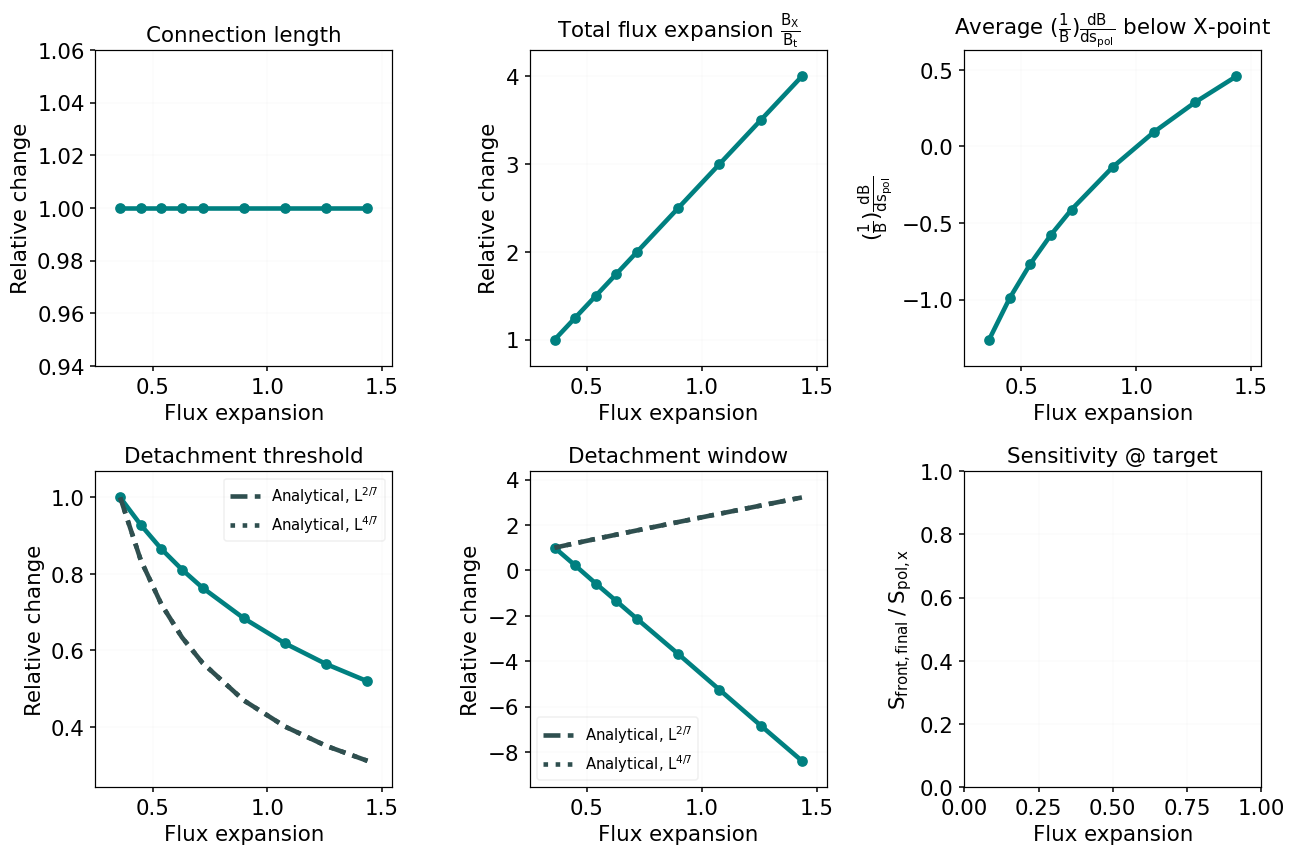

In [38]:
plot_morph_results(profiles, store, xlabel = "Flux expansion")

# Outer BxBt scan

In [213]:
store = dict()
profiles = pstore["outer_BxBt"]

# for i in [list(profiles.keys())[1]]:
for i in profiles:
    print(f"\n Profile: {i:.3f}")
    d = profiles[i].copy()
    fullrange = np.linspace(0, d["S"][d["Xpoint"]-1], 10) # Solve at these parallel positions
    
    # SparRange = [list(fullrange)[5]]
    SparRange = fullrange
    
    constants = constants_default.copy()
    if "i" in side:
        constants["qpllu0"] = 1.1e9
    if "o" in side:
        constants["qpllu0"] = 2.0e9

    results = LRBv21(constants, radios_default.copy(), 
                     d, 
                     SparRange, 
                     verbosity = 1, 
                     control_variable = "density", 
                     Ctol = 1e-3, Ttol=1e-3)
    
    store[i] = copy.deepcopy(results)


 Profile: 1.0808072630393293
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 19.9 seconds

 Profile: 1.3510090787991615
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 20.3 seconds

 Profile: 1.621210894558994
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 21.5 seconds

 Profile: 1.8914127103188263
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 19.7 seconds

 Profile: 2.1616145260786586
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 19.4 seconds

 Profile: 2.702018157598323
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 20.8 seconds

 Profile: 3.242421789117988
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 20.4 seconds

 Profile: 3.7828254206376526
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 19.3 seconds

 Profile: 4.323229052157317
Solving...0...24...42...55...63...68...71...72...73...74...Com

C:\Users\mikek\AppData\Local\Temp\ipykernel_64380\1550407324.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Spectral_r', 9)


Text(0.5, 1.0, 'Front position response to upstream density')

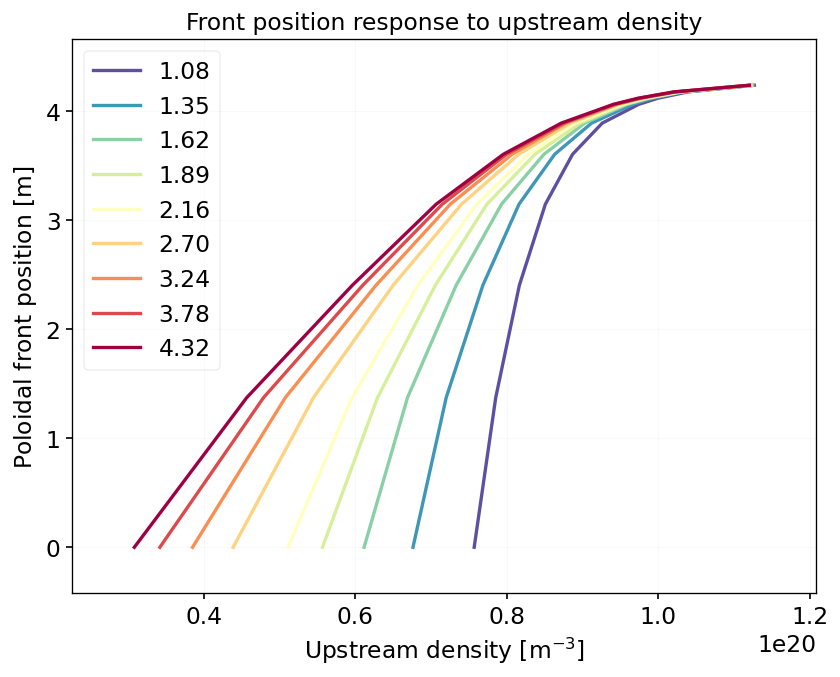

In [214]:
fig, ax = plt.subplots()
style = dict(lw = 2)

cmap = mpl.cm.get_cmap('Spectral_r', 9)
colors = [cmap(x) for x in np.linspace(0,1, len(profiles))]
for i, id in enumerate(profiles):
    s = store[id]
    ax.plot(s["cvar_trim"], s["SpolPlot"], label = f"{id:.2f}", color = colors[i], **style)
    
ax.legend()
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()

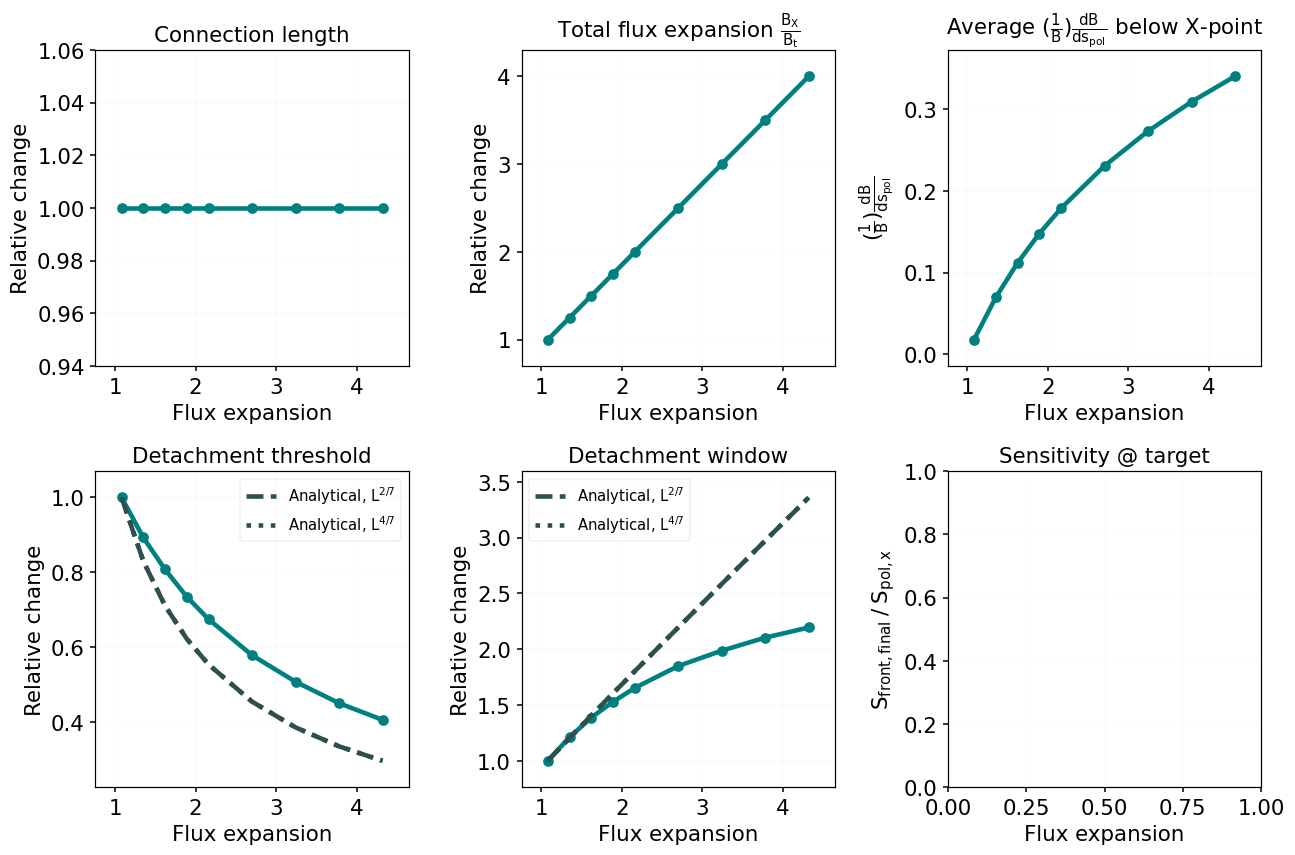

In [221]:
plot_morph_results(profiles, store, xlabel = "Flux expansion")